## Library

In [1]:
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 7.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 10.8 MB/s eta 0:00:00


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
from tqdm import tqdm
from skimage.transform import resize
import cv2
from typing import Type

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

from torchvision import transforms, models
from scipy.ndimage import rotate
from skimage.transform import resize
from scipy.ndimage import gaussian_filter

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

US1_J2KR.dcm:   0%|          | 38.0/154k [00:00<01:03, 2.42kB/s]
MR-SIEMENS-DICOM-WithOverlays.dcm:   0%|          | 125/511k [00:00<01:49, 4.65kB/s]
OBXXXX1A.dcm:   0%|          | 119/486k [00:00<02:02, 3.96kB/s]
US1_UNCR.dcm:   0%|          | 226/923k [00:00<02:27, 6.26kB/s]
color3d_jpeg_baseline.dcm:   0%|          | 1.50k/6.14M [00:00<05:35, 18.3kB/s]


In [3]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## Init GPU

In [4]:
# Initialize GPU Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

print(device)

GPU: Tesla P100-PCIE-16GB is available.
cuda


In [5]:
%load_ext autoreload
%autoreload 2

## Config Info

In [6]:
# Constants
HEIGHT = 224
WIDTH = 224
CHANNELS = 3

TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
TEST_BATCH_SIZE = 4
TEST_SIZE = 0.15
VALID_SIZE = 0.15

MAX_SLICES = 60
SHAPE = (HEIGHT, WIDTH, CHANNELS)

NUM_EPOCHS = 1
LEARNING_RATE = 1e-3
INDUCING_POINTS = 128

# TARGET_LABELS = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
TARGET_LABELS = ['intraparenchymal']

MODEL_PATH = 'trained_model.pth'
DEVICE = 'cuda'

In [7]:
# Kaggle and local switch
KAGGLE = os.path.exists('/kaggle')
print("Running on Kaggle" if KAGGLE else "Running locally")
ROOT_DIR = '/kaggle/input/' if KAGGLE else None
DATA_DIR = ROOT_DIR + 'rsna-mil-training/' if KAGGLE else '../rsna-mil-training/'
DICOM_DIR = DATA_DIR + 'rsna-mil-training/'
CSV_PATH = DATA_DIR + 'training_1000_scan_subset.csv' if KAGGLE else './data_analyze/training_1000_scan_subset.csv'
SLICE_LABEL_PATH = ROOT_DIR + "sorted_training_dataset_with_labels.csv" if KAGGLE else './data_analyze/sorted_training_dataset_with_labels.csv'

dicom_dir = DICOM_DIR if KAGGLE else DATA_DIR
# Load patient scan labels
patient_scan_labels = pd.read_csv(CSV_PATH)
patient_slice_labels = pd.read_csv(SLICE_LABEL_PATH)

Running on Kaggle


## Data Preprocessing

In [8]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    
    # Resize
    img = cv2.resize(img, SHAPE[:2], interpolation = cv2.INTER_LINEAR)
   
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    
    bsb_img = np.stack([brain_img, subdural_img, soft_img], axis=-1)
    return bsb_img.astype(np.float16)

In [9]:
def preprocess_slice(slice, target_size=(HEIGHT, WIDTH)):
    # Check if type of slice is dicom or an empty numpy array
    if (type(slice) == np.ndarray):
        slice = resize(slice, target_size, anti_aliasing=True)
        multichannel_slice = np.stack([slice, slice, slice], axis=-1)
        return multichannel_slice.astype(np.float16)
    else:
        slice = bsb_window(slice)
        return slice.astype(np.float16)

In [10]:
def read_dicom_folder(folder_path):
    slices = []
    for filename in sorted(os.listdir(folder_path))[:MAX_SLICES]:  # Limit to MAX_SLICES
        if filename.endswith(".dcm"):
            file_path = os.path.join(folder_path, filename)
            ds = pydicom.dcmread(file_path)
            slices.append(ds)
            
    # Sort slices by images position (z-coordinate) in ascending order
    slices = sorted(slices, key=lambda x: float(x.ImagePositionPatient[2]))
    
    # Pad with black images if necessary
    while len(slices) < MAX_SLICES:
        slices.append(np.zeros_like(slices[0].pixel_array))
    
    return slices[:MAX_SLICES]  # Ensure we return exactly MAX_SLICES

## Dataset and DataLoader

### Splitting the Dataset

In [11]:
def split_dataset(patient_scan_labels, test_size=TEST_SIZE, val_size=VALID_SIZE, random_state=42):
    # If any of the hemorrhage indicators is 1, the label is 1, otherwise 0
    patient_scan_labels['label'] = patient_scan_labels[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].any(axis=1).astype(int)

    # Extract the labels from the DataFrame
    labels = patient_scan_labels['label']

    # First, split off the test set
    train_val_labels, test_labels = train_test_split(
        patient_scan_labels, 
        test_size=test_size, 
        stratify=labels, 
        random_state=random_state
    )

    # Calculate the validation size relative to the train_val set
    val_size_adjusted = val_size / (1 - test_size)

    # Split the train_val set into train and validation sets
    train_labels, val_labels = train_test_split(
        train_val_labels, 
        test_size=val_size_adjusted, 
        stratify=train_val_labels['label'], 
        random_state=random_state
    )

    return train_labels, val_labels, test_labels

### Processing the Data

In [12]:
def process_patient_data(dicom_dir, row, num_instances=12, depth=5):
    patient_id = row['patient_id'].replace('ID_', '')
    study_instance_uid = row['study_instance_uid'].replace('ID_', '')
    
    folder_name = f"{patient_id}_{study_instance_uid}"
    folder_path = os.path.join(dicom_dir, folder_name)
    
    if os.path.exists(folder_path):
        slices = read_dicom_folder(folder_path)
        
        # Ensure we have enough slices to create the specified instances
        if len(slices) < depth * num_instances:
            print(f"Not enough slices for patient {patient_id}: found {len(slices)}, needed {depth * num_instances}")
            return None, None
        
        preprocessed_slices = [preprocess_slice(slice) for slice in slices]
        
        # Stack preprocessed slices into an array
        preprocessed_slices = np.stack(preprocessed_slices, axis=0)  # (num_slices, height, width, channels)
        
        # Reshape to (num_instances, depth, height, width, channels)
        # reshaped_slices = preprocessed_slices[:num_instances * depth].reshape(num_instances, depth, *preprocessed_slices.shape[1:])  # (num_instances, depth, height, width, channels)
        
        # Labeling remains consistent  
        label = 1 if row[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].any() else 0
        
        # return reshaped_slices, label
        return preprocessed_slices, label
    
    else:
        print(f"Folder not found: {folder_path}")
        return None, None

In [13]:
def find_matching_row(patient_id, study_instance_uid, patient_slice_labels):
    # Filter for matching rows based on patient_id and study_instance_uid
    matching_row = patient_slice_labels[
        (patient_slice_labels['patient_id'] == patient_id) & 
        (patient_slice_labels['study_instance_uid'] == study_instance_uid)
    ]
    return matching_row

def prepare_labels_for_images(images, patient_slice_labels, patient_id, study_instance_uid):
    # Get matching rows
    matching_rows = find_matching_row(patient_id, study_instance_uid, patient_slice_labels)
    
    # Initialize labels with zeros
    labels = [0] * len(images)
    
    # Check if there are any matching rows
    if not matching_rows.empty:
        # Create a boolean mask for the relevant columns
        mask = matching_rows[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].any(axis=1)
        
        # Assign labels based on the mask
        for i in range(min(len(images), len(matching_rows))):
            if mask.iloc[i]:
                labels[i] = 1
                
    return labels

### Dataset Generator

In [14]:
class TrainDatasetGenerator(Dataset):
    """
    A custom dataset class for training data.
    """
    def __init__(self, data_dir, patient_scan_labels):
        self.data_dir = data_dir
        self.patient_scan_labels = patient_scan_labels

    def __len__(self):
        return len(self.patient_scan_labels)

    def __getitem__(self, idx):
        row = self.patient_scan_labels.iloc[idx]
        preprocessed_slices, label = process_patient_data(self.data_dir, row)
        patient_study_instance = prepare_labels_for_images(np.array(preprocessed_slices), patient_slice_labels, row['patient_id'], row['study_instance_uid'])
        if preprocessed_slices is not None:
            # Convert the list of numpy arrays to a single numpy array
            preprocessed_slices = np.array(preprocessed_slices)  # Convert to numpy array
            return torch.tensor(preprocessed_slices, dtype=torch.float32), torch.tensor(label, dtype=torch.long), torch.tensor(patient_study_instance, dtype=torch.long)
        else:
            return None, None, None  # Handle the case where the folder is not found

class TestDatasetGenerator(Dataset):
    """
    A custom dataset class for testing data.
    """
    def __init__(self, data_dir, patient_scan_labels):
        self.data_dir = data_dir
        self.patient_scan_labels = patient_scan_labels

    def __len__(self):
        return len(self.patient_scan_labels)

    def __getitem__(self, idx):
        row = self.patient_scan_labels.iloc[idx]
        preprocessed_slices, label = process_patient_data(self.data_dir, row)
        patient_study_instance = prepare_labels_for_images(np.array(preprocessed_slices), patient_slice_labels, row['patient_id'], row['study_instance_uid'])
        if preprocessed_slices is not None:
            # Convert the list of numpy arrays to a single numpy array
            preprocessed_slices = np.array(preprocessed_slices)  # Convert to numpy array
            return torch.tensor(preprocessed_slices, dtype=torch.float32), torch.tensor(label, dtype=torch.long), torch.tensor(patient_study_instance, dtype=torch.long)
        else:
            return None, None, None  # Handle the case where the folder is not found

In [15]:
def get_train_loader(dicom_dir, patient_scan_labels, batch_size=TRAIN_BATCH_SIZE):
    original_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels)
    return DataLoader(original_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

def get_test_loader(dicom_dir, patient_scan_labels, batch_size=TEST_BATCH_SIZE):
    test_dataset = TestDatasetGenerator(dicom_dir, patient_scan_labels)
    return DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

## CNN Feature Extractor

In [16]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.fc = nn.Identity()  # Remove the final classification layer
        self.classifier = nn.Linear(512, 1)  # Binary classification
        self.dropout = nn.Dropout(0.4)
      
    def forward(self, x):
        # x.shape: (batch_size, num_instances, channels, height, width)
        batch_size, num_instances, channels, height, width = x.size()        
        
        # Flatten to (batch_size * num_instances, channels, height, width)
        x_flattened = x.reshape(-1, x.size(4), x.size(2), x.size(3))    
        
        # Get features from ResNet
        features = self.resnet(x_flattened)  # Shape: (batch_size * num_instances, 512)
        
        # dropped_features = self.dropout(aggregated_features)
        dropped_features = self.dropout(features)
        
        # Classify
        outputs = torch.sigmoid(self.classifier(dropped_features))
        
        return outputs

## Training and Evaluation

### Training

In [17]:
def train_epoch(model, data_loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    alpha = 0.5
    predictions = []
    all_labels = []
    
    for batch_slices, _, batch_slices_labels in data_loader:
        batch_slices = batch_slices.to(device)
        batch_slices_labels = batch_slices_labels.float().to(device)
    
        optimizer.zero_grad()
        outputs = model(batch_slices)
        batch_slices_labels = batch_slices_labels.view(-1, 1)  # Reshape to [480, 1] if there are 480 total elements
        # outputs = outputs.squeeze()
        loss = criterion(outputs, batch_slices_labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        predictions.extend((outputs > 0).cpu().numpy())
        all_labels.extend(batch_slices_labels.cpu().numpy())
        
    return total_loss, predictions, all_labels

def validate(model, data_loader, criterion, device):
    """Validate the model."""
    model.eval()
    total_loss = 0.0
    alpha = 0.5
    predictions = []
    all_labels = []

    with torch.no_grad():
        for batch_slices, _, batch_slices_labels in data_loader:
            batch_slices = batch_slices.to(device)
            batch_slices_labels = batch_slices_labels.float().to(device)

            outputs = model(batch_slices)
            batch_slices_labels = batch_slices_labels.view(-1, 1)
            # outputs = outputs.squeeze()
                        
            loss = criterion(outputs, batch_slices_labels)
        
            total_loss += loss.item()
            predictions.extend((outputs > 0).cpu().numpy())
            all_labels.extend(batch_slices_labels.cpu().numpy())
   
    return total_loss, predictions, all_labels

def calculate_metrics(predictions, labels):
    """Calculate and return performance metrics."""
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions, average='macro'),
        "recall": recall_score(labels, predictions, average='macro'),
        "f1": f1_score(labels, predictions, average='macro')
    }

def print_epoch_stats(epoch, num_epochs, phase, loss, metrics):
    """Print statistics for an epoch."""
    print(f"Epoch {epoch+1}/{num_epochs} - {phase.capitalize()}:")
    print(f"Loss: {loss:.4f}, Accuracy: {metrics['accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, "
          f"F1: {metrics['f1']:.4f}")

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, learning_rate, device='cuda'):
    """Train the model and return the best model based on validation accuracy."""
    model = model.to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                                              steps_per_epoch=len(train_loader), epochs=num_epochs)
    
    best_val_accuracy = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        train_loss, train_predictions, train_labels = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
        train_metrics = calculate_metrics(train_predictions, train_labels)
        print_epoch_stats(epoch, num_epochs, "train", train_loss, train_metrics)

        # Validation phase
        val_loss, val_predictions, val_labels = validate(model, val_loader, criterion, device)
        val_metrics = calculate_metrics(val_predictions, val_labels)
        print_epoch_stats(epoch, num_epochs, "validation", val_loss, val_metrics)

        # Save best model
        if val_metrics['accuracy'] > best_val_accuracy:
            best_val_accuracy = val_metrics['accuracy']
            best_model_state = model.state_dict()

    # Check if best_model_state was updated
    if best_model_state is None:
        print("Warning: No improvement in validation accuracy; returning the initial model state.")
    
    # Load best model state if available
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        
    return model

### Evaluation Functions

In [18]:
## Model Evaluation Functions
def evaluate_model(model, data_loader, device='cuda'):
    """Evaluate the model on the given data loader."""
    model = model.to(device)
    model.eval()
    predictions = []
    labels = []

    with torch.no_grad():
        for batch_slices, _, batch_slices_labels in data_loader:
            batch_slices = batch_slices.to(device)
            batch_slices_labels = batch_slices_labels.float().to(device)

            outputs = model(batch_slices)
            # outputs = outputs.squeeze()
            
            predictions.extend((outputs > 0).cpu().numpy())
            labels.extend(batch_slices_labels.cpu().numpy())

    return np.array(predictions).flatten(), np.array(labels).flatten()

def print_metrics(metrics):
    """Print the calculated metrics."""
    print(f"Test Accuracy: {metrics['accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, "
          f"Recall: {metrics['recall']:.4f}, "
          f"F1: {metrics['f1']:.4f}")

### Visualization Functions

In [19]:
## Visualization Functions
def plot_roc_curve(model, data_loader, device):
    """Plot the ROC curve for the model predictions."""
    # predictions, labels = evaluate_model(model, data_loader, device)
    
    model.eval()
    labels = []
    predictions = []
    with torch.no_grad():
        for batch_slices, _, batch_slices_labels in data_loader:
            batch_slices = batch_slices.to(device)
            batch_slices_labels = batch_slices_labels.float().to(device)

            outputs = model(batch_slices)
            # outputs = outputs.squeeze()
            predictions.extend((outputs > 0).cpu().numpy())
            labels.extend(batch_slices_labels.cpu().numpy())
            
    predictions = np.array(predictions).flatten()
    labels = np.array(labels).flatten()
            
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, data_loader, device):
    """Plot the confusion matrix for the model predictions."""
    predictions, labels = evaluate_model(model, data_loader, device)
    
    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

### Data Processing Functions

In [20]:
## Data Processing Functions
def load_model(model_class, model_path):
    """Load a trained model from a file."""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")

    model = model_class()
    try:
        state_dict = torch.load(model_path, map_location=torch.device('cuda'), weights_only=True)
        if not state_dict:
            raise ValueError(f"The state dictionary loaded from {model_path} is empty")
        model.load_state_dict(state_dict)
    except Exception as e:
        print(f"Error loading model from {model_path}: {str(e)}")
        print("Initializing model with random weights instead.")
        return model  # Return the model with random initialization

    return model.eval()


def get_test_results(model, test_loader, test_labels):
    """Get test results including patient information."""
    predictions, _ = evaluate_model(model, test_loader)
    
    results = []
    for i, row in enumerate(test_labels.itertuples(index=False)):
        result = {col: getattr(row, col) for col in test_labels.columns}
        result['prediction'] = predictions[i]
        results.append(result)
    
    return pd.DataFrame(results)

## Visualizing Attention Weights and Images

In [21]:
def separate_patient_study_instance(patient_study_instance):
    # ID_000012eaf_ID_5c8b5d701, split them into ID_000012eaf and ID_5c8b5d701
    split_criteria = '_ID_'
    patient_id, study_instance_uid = patient_study_instance.rsplit(split_criteria, 1)
    
    return patient_id, 'ID_' + study_instance_uid

def plot_images_with_attention(images, labels, patient_study_instance):
    print(f'Images shape: {images.shape}')
    num_images = images.size(0)
    images = images.numpy()
    
    patient_id, study_instance_uid = separate_patient_study_instance(patient_study_instance)
    slice_labels = prepare_labels_for_images(images, patient_slice_labels, patient_id, study_instance_uid)
    
    # Calculate number of rows needed (60 images with 4 per row)
    num_rows = num_images // 4 + (num_images % 4 > 0)  # Add an extra row if there's a remainder
    
    plt.figure(figsize=(15, num_rows * 3))  # Adjust height based on number of rows
    
    for i in range(num_images):
        plt.subplot(num_rows, 4, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Image {i + 1} - Label: {slice_labels[i]}')
        plt.axis('off')
    
    plt.tight_layout() 
    plt.show()
    
def test_patient_bag(model, patient_data):
    model.eval()
    with torch.no_grad():
        for batch_data, batch_labels, patient_study_instance in patient_data:
            batch_data = batch_data.to(device)  # Move data to device
            batch_labels = batch_labels.float().to(device)
            outputs = model(batch_data)  # Get outputs and attention weights
            # outputs = outputs.squeeze()  # Remove extra dimension
            
            # Aggregate predictions across instances (x)
            bag_predictions = (outputs > 0).cpu().numpy()
            print("Bag Prediction:", bag_predictions)
            print("Labels: ", batch_labels.cpu().numpy())
                
            # Plot the images with attention weights
            # plot_images_with_attention(batch_data[0].cpu(), batch_labels[0].cpu(), patient_study_instance[0])
            
            break  # Only test one patient

## Main

In [22]:
## Main Execution
def main(mode='train'):
    train_labels, val_labels, test_labels = split_dataset(patient_scan_labels, test_size=TEST_SIZE)
    train_loader = get_train_loader(dicom_dir, train_labels, batch_size=TRAIN_BATCH_SIZE)
        
    val_loader = get_train_loader(dicom_dir, val_labels, batch_size=VALID_BATCH_SIZE)
    test_loader = get_test_loader(dicom_dir, test_labels, batch_size=TEST_BATCH_SIZE)
    
    # Initialize model, criterion, and optimizer
    model = ResNet18().to(DEVICE)
    criterion = torch.nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    if mode == 'train':
        # Train model
        trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, LEARNING_RATE, DEVICE)
        
        # Save model
        torch.save(trained_model.state_dict(), MODEL_PATH)

    ## Put foo function's contents here
    
    # Call the function with the test_loader
    # test_loader = get_test_loader(dicom_dir, test_labels, batch_size=2)
    # test_patient_bag(trained_model, test_loader)

if __name__ == "__main__":
    main(mode='train')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


Epoch 1/1 - Train:
Loss: 64.2761, Accuracy: 0.1024, Precision: 0.0512, Recall: 0.5000, F1: 0.0929
Epoch 1/1 - Validation:
Loss: 26.3748, Accuracy: 0.0973, Precision: 0.0487, Recall: 0.5000, F1: 0.0887


Test Accuracy: 0.0873, Precision: 0.0437, Recall: 0.5000, F1: 0.0803


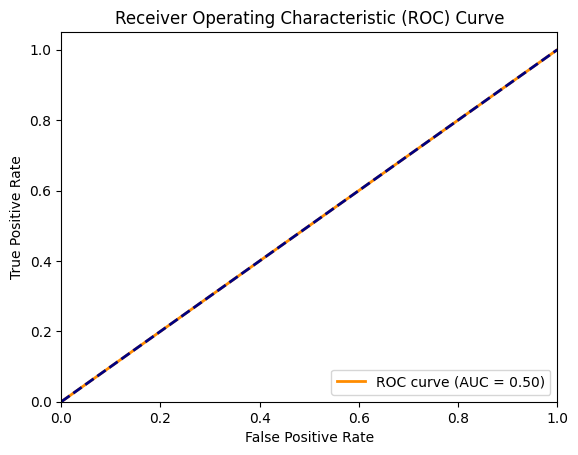

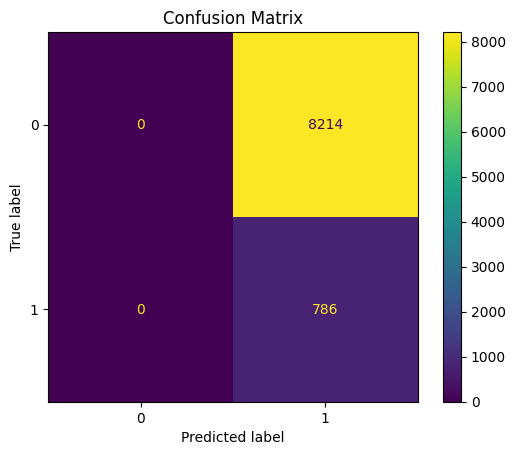

    patient_id study_instance_uid  label  prediction
0  ID_0748e0c1      ID_286183702b      0        True
1  ID_1528ff50      ID_5d0a50f3db      1        True
2  ID_07d4f582      ID_8b1137e5bc      0        True
3  ID_03131dd0      ID_a4ed78f57e      0        True
4  ID_05e0a4a1      ID_9dd14f9fa3      1        True


In [23]:
def debug(mode):
    train_labels, val_labels, test_labels = split_dataset(patient_scan_labels, test_size=TEST_SIZE)
    test_loader = get_test_loader(dicom_dir, test_labels, batch_size=TEST_BATCH_SIZE)
    
    # Load best model
    trained_model = load_model(ResNet18, MODEL_PATH)
    # Evaluate model
    predictions, labels = evaluate_model(trained_model, test_loader, DEVICE)
    metrics = calculate_metrics(predictions, labels)
    print_metrics(metrics)

    # Visualizations
    plot_roc_curve(trained_model, test_loader, DEVICE)
    plot_confusion_matrix(trained_model, test_loader, DEVICE)
    
    if mode == 'train':
        # Select only the required columns
        required_columns = ['patient_id', 'study_instance_uid', 'label']
        temp_test_labels = test_labels[required_columns]
        
        # Save results
        results_df = get_test_results(trained_model, test_loader, temp_test_labels)
        results_df.to_csv('results.csv', index=False)
        print(results_df.head())
        
debug(mode="train")